# Class Conditional CNN GAN
Generative Adversarial Network created to generate samples given a class label. 
This code is based on:
1. "Conditional Generative Adversarial Nets" by Mehdi Mirza, Simon Osindero. https://arxiv.org/abs/1411.1784
2. https://github.com/osh/KerasGAN
3. https://github.com/r0nn13/conditional-dcgan-keras 



In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

from keras.models import Model

from keras.layers import Input, merge
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten#, MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D, ZeroPadding1D, Deconvolution2D, Conv2D, Conv2DTranspose

from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad
from keras.datasets import mnist

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 770 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5005)


In [2]:
from keras.layers import concatenate

In [3]:
from keras.utils import np_utils

In [4]:
import time
from IPython import display

## Import and preprocess MNIST data

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
nb_classes = np.unique(y_train).shape[0]

In [7]:
img_rows, img_cols = x_train.shape[1:]

In [8]:
print 'Image dimensions: {} x {}'.format(img_rows, img_cols)
print 'Num. categories: {}'.format(len(np.unique(y_train)))
print 'Num. train samples: {}'.format(x_train.shape[0])
print 'Num. test samples: {}'.format(x_test.shape[0])

Image dimensions: 28 x 28
Num. categories: 10
Num. train samples: 60000
Num. test samples: 10000


Reshape images so that they are compatible with Keras / Theano.  
Convert images to float32 so that neural network can be trainined using the GPU.  
Scale image values so that they work well with the neural network.  

In [9]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = x_train/255, x_test/255

Label for image index 10: 3
Image:


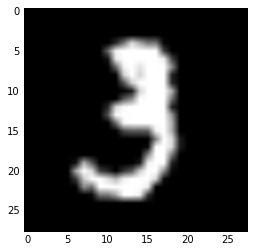

In [10]:
i = 10
print 'Label for image index {}: {}'.format(i, y_train[i])
print 'Image:'
plt.imshow(x_train[i,:,:,0], cmap=plt.cm.gray);

## Create the GAN model

In [11]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

### Generator

In [12]:
noise_dim = 134
nb_classes = 10

In [13]:
g_opt = Adam(lr=1e-4)
g_opt = Adam()

In [14]:
g_input_noise = Input(shape=[noise_dim], name='noise input')

g_input_label = Input(shape=[nb_classes], name = 'label input')
g_input_label_2 = Dense(50, kernel_initializer='glorot_normal')(g_input_label)
# g_input_label_2 = BatchNormalization(mode=2)(g_input_label_2)
g_input_label_2 = Activation('relu')(g_input_label_2)

g_input = concatenate([g_input_noise, g_input_label_2])

g = Dense(200*14*14, kernel_initializer='glorot_normal')(g_input)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Reshape([14, 14, 200])(g)
g = UpSampling2D(size=(2, 2))(g)

g = Conv2D(256, (3, 3), padding='same', kernel_initializer='glorot_normal')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Conv2D(128, (3, 3), padding='same', kernel_initializer='glorot_normal')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Convolution2D(1, (1, 1), padding='same', kernel_initializer='glorot_normal')(g)
g_output = Activation('sigmoid')(g)

generator = Model([g_input_noise, g_input_label], g_output)
# generator.compile(loss='binary_crossentropy', optimizer=g_opt)

In [16]:
g_input_noise = Input(shape=[noise_dim], name='noise input')

g_input_label = Input(shape=[nb_classes], name = 'label input')
g_input_label_2 = Dense(50, kernel_initializer='glorot_normal')(g_input_label)
# g_input_label_2 = BatchNormalization(mode=2)(g_input_label_2)
g_input_label_2 = Activation('relu')(g_input_label_2)

g_input = concatenate([g_input_noise, g_input_label_2])

g = Dense(50*14*14, kernel_initializer='glorot_normal')(g_input)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Reshape([14, 14, 50])(g)
g = UpSampling2D(size=(2, 2))(g)

g = Conv2D(256, (3, 3), padding='same', kernel_initializer='glorot_normal')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Conv2D(128, (3, 3), padding='same', kernel_initializer='glorot_normal')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_normal')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Convolution2D(1, (1, 1), padding='same', kernel_initializer='glorot_normal')(g)
g_output = Activation('sigmoid')(g)

generator = Model([g_input_noise, g_input_label], g_output)
# generator.compile(loss='binary_crossentropy', optimizer=g_opt)

In [17]:
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
label input (InputLayer)         (None, 10)            0                                            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 50)            550                                          
____________________________________________________________________________________________________
noise input (InputLayer)         (None, 134)           0                                            
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 50)            0                                            
___________________________________________________________________________________________

In [ ]:
g_input_noise = Input(shape=[100], name='noise input')

g_input_label = Input(shape=[nb_classes], name = 'label input')
g_input_label_2 = Dense(50, init='glorot_normal')(g_input_label)
# g_input_label_2 = BatchNormalization(mode=2)(g_input_label_2)
g_input_label_2 = Activation('relu')(g_input_label_2)

g_input = merge([g_input_noise, g_input_label_2], mode='concat', concat_axis=1)

g = Dense(200*14*14, init='glorot_normal')(g_input)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)


g = Reshape([200, 14, 14])(g)
g = UpSampling2D(size=(2, 2))(g)

g = Convolution2D(100, 3, 3, padding='same', init='glorot_normal')(g)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)
g = Dropout(0.25)(g)

g = Convolution2D(50, 3, 3, padding='same', init='glorot_normal')(g)
g = BatchNormalization(mode=2)(g)
g = Activation('relu')(g)
g = Dropout(0.25)(g)

g = Convolution2D(1, 1, 1, padding='same', init='glorot_normal')(g)
g_output = Activation('sigmoid')(g)

generator = Model([g_input_noise, g_input_label], g_output)
# generator.compile(loss='binary_crossentropy', optimizer=g_opt)

#### Generator using Conv Transpose

In [ ]:
g_input_noise = Input(shape=[noise_dim], name='noise input')
g_input_label = Input(shape=[nb_classes], name = 'label input')
g_input = concatenate([g_input_noise, g_input_label])
g = Reshape([12, 12, 1])(g_input)

g = Conv2DTranspose(100, (3, 3), padding='valid')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Conv2DTranspose(50, (3, 3), strides=(2,2), padding='same')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Conv2DTranspose(25, (3, 3), padding='same')(g)
g = BatchNormalization()(g)
g = Activation('relu')(g)

g = Conv2DTranspose(1, (1, 1), padding='same')(g)
g = BatchNormalization()(g)
g_output = Activation('sigmoid')(g)

generator = Model([g_input_noise, g_input_label], g_output)
generator.compile(loss='binary_crossentropy', optimizer=g_opt)

In [ ]:
generator.summary()

#### Generator from the Conditional GAN Paper [Mehdi, 2014]

In [ ]:
# g_input_noise = Input(shape=[100], name='noise input')
# g_input_noise_2 = Dense(200, activation='relu')(g_input_noise)

# g_input_label = Input(shape=[nb_classes], name = 'label input')
# g_input_label_2 = Dense(1000, activation='relu')(g_input_label)

# g_input = merge([g_input_noise_2, g_input_label_2], mode='concat', concat_axis=1)

# g = Dense(1200, activation='relu')(g_input)
# g = Dense(28*28, activation='sigmoid')(g)
# g_output = Reshape(x_train.shape[1:])(g)

# generator = Model([g_input_noise, g_input_label], g_output)

In [ ]:
# generator.summary()

### Discriminator

In [18]:
d_opt = Adam(lr=1e-4)
# d_opt = Adam()
# d_opt = SGD(lr=0.01, momentum=0, decay=0)
# d_opt = Adagrad()

#### Label added as an image

In [ ]:
d_input_img = Input(shape=x_train.shape[1:], name='image input')

d_input_label = Input(shape=[nb_classes], name='label input')
# d_input_label_2 = Reshape((10,1))(d_input_label)
# d_input_label_2 = ZeroPadding1D(padding=(0,6))(d_input_label_2)
# d_input_label_2 = Reshape((1,4,4))(d_input_label_2)
# d_input_label_2 = UpSampling2D(size=(7,7))(d_input_label_2)
d_input_label_2 = Dense(28*28, activation='relu')(d_input_label)
d_input_label_2 = Reshape(x_train.shape[1:])(d_input_label_2)

d_input = concatenate([d_input_img, d_input_label_2])

d = Convolution2D(256, (5, 5), strides=(2, 2), padding='same')(d_input)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, (5, 5), strides=(2, 2), padding='same')(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = Dense(256)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2, activation='softmax')(d)

discriminator = Model([d_input_img, d_input_label], d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [ ]:
discriminator.summary()

#### Moved Label layer closer to the fully connected layer

In [19]:
d_input_img = Input(shape=x_train.shape[1:], name='image input')
d_input_label = Input(shape=[nb_classes], name='label input')

d = Convolution2D(256, (5, 5), strides=(2, 2), padding='same')(d_input_img)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, (5, 5), strides=(2, 2), padding='same')(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = concatenate([d, d_input_label])
d = Dense(256)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2, activation='softmax')(d)

discriminator = Model([d_input_img, d_input_label], d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [20]:
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image input (InputLayer)         (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 14, 14, 256)   6656                                         
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 14, 14, 256)   0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 14, 14, 256)   0                                            
___________________________________________________________________________________________

In [ ]:
d_input_img = Input(shape=x_train.shape[1:], name='image input')
d_input_label = Input(shape=[nb_classes], name='label input')

d = Convolution2D(256, (5, 5), strides=(2, 2), padding='same')(d_input_img)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, (5, 5), strides=(2, 2), padding='same')(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = concatenate([d, d_input_label])
d = Dense(256)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2, activation='softmax')(d)

discriminator = Model([d_input_img, d_input_label], d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [ ]:
discriminator.summary()

In [17]:
d_input_img = Input(shape=x_train.shape[1:], name='image input')
d_input_label = Input(shape=[nb_classes], name='label input')

d = Convolution2D(64, (5, 5), strides=(1, 1), padding='same')(d_input_img)
d = BatchNormalization()(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(256, (5, 5), strides=(2, 2), padding='same')(d)
d = BatchNormalization()(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, (5, 5), strides=(2, 2), padding='same')(d)
d = BatchNormalization()(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = concatenate([d, d_input_label])
d = Dense(50)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2, activation='softmax')(d)

discriminator = Model([d_input_img, d_input_label], d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [ ]:
discriminator.summary()

#### No label input. 2*nb_classes output

In [ ]:
d_input_img = Input(shape=x_train.shape[1:], name='image input')

d = Convolution2D(64, (5, 5), strides=(2, 2), padding='same')(d_input_img)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(256, (5, 5), strides=(2, 2), padding='same')(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, (5, 5), strides=(2, 2), padding='same')(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = Dense(256)(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2*nb_classes, activation='softmax')(d)

discriminator = Model(d_input_img, d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [ ]:
discriminator.summary()

#### Using Batch Norm and Moved Label layer closer to the fully connected layer

In [ ]:
d_input_img = Input(shape=x_train.shape[1:], name='image input')

d_input_label = Input(shape=[nb_classes], name='label input')
# d_input_label_2 = Reshape((10,1))(d_input_label)
# d_input_label_2 = ZeroPadding1D(padding=(0,6))(d_input_label_2)
# d_input_label_2 = Reshape((1,4,4))(d_input_label_2)
# d_input_label_2 = UpSampling2D(size=(7,7))(d_input_label_2)
# d_input_label_2 = Dense(28*28, activation='relu')(d_input_label)
# d_input_label_2 = Reshape(x_train.shape[1:])(d_input_label_2)

# d_input = merge([d_input_img, d_input_label_2], mode='concat', concat_axis=1)

d = Convolution2D(256, (5, 5), strides=(2, 2), padding='same')(d_input_img)
d = BatchNormalization()(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Convolution2D(512, (5, 5), strides=(2, 2), padding='same')(d)
d = BatchNormalization()(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d = Flatten()(d)
d = concatenate([d, d_input_label])
d = Dense(256)(d)
d = BatchNormalization()(d)
d = LeakyReLU(0.2)(d)
d = Dropout(0.25)(d)

d_output = Dense(2, activation='softmax')(d)

discriminator = Model([d_input_img, d_input_label], d_output)
discriminator.compile(loss='categorical_crossentropy', optimizer=d_opt)

In [ ]:
discriminator.summary()

#### Discriminator from the Conditional GAN Paper [Mehdi, 2014]

In [ ]:
# d_input_img = Input(shape=x_train.shape[1:], name='image input')
# d_input_img_2 = MaxoutDense(240, nb_feature=5)(d_input_img)

# d_input_label = Input(shape=[10], name='label input')
# d_input_label_2 = MaxoutDense(50, nb_feature=5)(d_input_label)
# d_input_label_2 = Reshape(x_train.shape[1:])(d_input_label_2)

# d_input = merge([d_input_img_2, d_input_label_2], mode='concat', concat_axis=1)

# d = MaxoutDense(240, nb_feature=4)(d_input)
# d = Activation('sigmoid')(d)

# discriminator = Model([d_input_img, d_input_label], d_output)
# discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

### Stack Generator and Discriminator

In [21]:
make_trainable(discriminator, False)
# discriminator.trainable = False

In [22]:
gan_opt = Adam(lr=1e-4)

In [23]:
gan_input_noise = Input(shape=[noise_dim])
gan_input_label = Input(shape=[nb_classes])

gan_input = concatenate([g_input_noise, g_input_label])
g_output = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([g_output, gan_input_label])
gan = Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(loss='categorical_crossentropy', optimizer=gan_opt)

In [ ]:
gan_input_noise = Input(shape=[noise_dim])
gan_input_label = Input(shape=[nb_classes])

gan_input = concatenate([g_input_noise, g_input_label])
g_output = generator([gan_input_noise, gan_input_label])
gan_output = discriminator(g_output)
gan = Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(loss='categorical_crossentropy', optimizer=gan_opt)

In [ ]:
# gan.summary()

## Train GAN

In [ ]:
# d_opt.lr.set_value(1e-2)
# gan_opt.lr.set_value(1e-3)

### Pre train Discriminator

In [24]:
# Sample real images
n = 10000
idx = np.random.randint(0, x_train.shape[0], size=n)
real_images = x_train[idx, :, :, :]

# Generate fake images
noise = np.random.uniform(0, 1, size=[n, noise_dim])
labels = np_utils.to_categorical(y_train[idx], num_classes = nb_classes)

fake_images = generator.predict([noise, labels], verbose=0)

In [25]:
# Combine real and fake images
x = np.concatenate((real_images, fake_images, real_images))

labels_wrong = np.random.randint(0, nb_classes, n)
labels_wrong = np_utils.to_categorical(labels_wrong, num_classes=nb_classes)

y = np.zeros([3*n, 2])
y[:n, 1] = 1  # set second feature of y to 1 for real images
y[n:, 0] = 1  # set first feature of y to 1 for fake images

labels_2 = np.concatenate((labels, labels, labels_wrong))

In [ ]:
y = np.zeros([2*n, 2*nb_classes])
y[:n, :nb_classes] = labels  
y[n:, nb_classes:] = labels

In [26]:
# Train the discriminator part of the network
make_trainable(discriminator, True)
discriminator.fit([x, labels_2], y, epochs=1, batch_size=32, verbose=2)

Epoch 1/1
60s - loss: 0.4610


In [ ]:
# Train the discriminator part of the network
make_trainable(discriminator, True)
discriminator.fit(x, y, epochs=1, batch_size=32, verbose=2)

In [ ]:
# d_loss = discriminator.train_on_batch(x, y)
# print 'D loss: {}'.format(d_loss)

### Train

In [27]:
def show_fake_images(n, g_model):
    noise = np.random.uniform(0, 1, size=[n, noise_dim])
    label = np.random.randint(0, 10, size=n)
    labels = np_utils.to_categorical(label, num_classes=nb_classes)
    fake_images = g_model.predict([noise, labels], verbose=0)

    for img, label in zip(fake_images, labels):
        print 'Fake image using label {}:'.format(np.argmax(label))
        plt.imshow(img[:,:,0], cmap=plt.cm.gray);
        plt.show();

In [28]:
batch_size = 32

In [29]:
d_losses, gan_losses = [], []

In [30]:
def train(epochs, d_losses, gan_losses):
    for epoch in range(epochs):
        start_time = time.time()
        # Sample real images
        idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        real_images = x_train[idx, :, :, :]

        # Generate fake images
        noise = np.random.uniform(0, 1, size=[batch_size, noise_dim])
        labels = np_utils.to_categorical(y_train[idx], num_classes=nb_classes)
        fake_images = generator.predict([noise, labels])

        # Combine real and fake images
        x = np.concatenate((real_images, fake_images, real_images))

        labels_wrong = np.random.randint(0, nb_classes, batch_size)
        labels_wrong = np_utils.to_categorical(labels_wrong, num_classes=nb_classes)

        y = np.zeros([3*batch_size, 2])
        y[:batch_size, 1] = 1  # set second feature of y to 1 for real images
        y[batch_size:, 0] = 1  # set first feature of y to 1 for fake images

        labels_2 = np.concatenate((labels, labels, labels_wrong))

        # Combine real and fake images
#         x = np.concatenate((real_images, fake_images))
#         y = np.zeros([2*batch_size, 2])
#         y[:batch_size, 1] = 1  # set second feature of y to 1 for real images
#         y[batch_size:, 0] = 1  # set first feature of y to 1 for fake images

        # Train the discriminator part of the network
    #     discriminator.trainable = True
#         labels_2 = np.concatenate((labels, labels))
        d_loss = discriminator.train_on_batch([x, labels_2], y)

        # Train the whole GAN network
        x = np.random.uniform(0, 1, size=[batch_size*3, noise_dim])
        labels = np_utils.to_categorical(np.random.randint(0, 10, size=batch_size), num_classes=nb_classes)
        y = np.zeros([batch_size*3, 2])
        y[:, 1] = 1
    #     discriminator.trainable = False
        gan_loss = gan.train_on_batch([x, np.concatenate((labels, labels, labels))], y)
        d_losses += [d_loss]
        gan_losses += [gan_loss]

        if epoch % 20 == 0:  
            display.clear_output(wait=True)
            print 'Epoch {} out of {}'.format(epoch, epochs)
            print 'D loss: {}'.format(d_loss)
            print 'GAN loss: {}'.format(gan_loss)
            print 'Time elapsed in epoch {}: {:.2f} seconds'.format(epoch, time.time()-start_time)
    #         display.display(plt.gcf())
            plt.plot(d_losses);
            plt.plot(gan_losses);
            plt.legend();
            plt.show();

            # Sample fake image
            show_fake_images(2, generator)

In [ ]:
def train(epochs, d_losses, gan_losses):
    for epoch in range(epochs):
        start_time = time.time()
        # Sample real images
        idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        real_images = x_train[idx, :, :, :]

        # Generate fake images
        noise = np.random.uniform(0, 1, size=[batch_size, noise_dim])
        labels = np_utils.to_categorical(y_train[idx], num_classes=nb_classes)
        fake_images = generator.predict([noise, labels])

        # Combine real and fake images
        x = np.concatenate((real_images, fake_images))
        y = np.zeros([2*batch_size, 2*nb_classes])
#         y[:batch_size, :nb_classes] = labels  
#         y[batch_size:, nb_classes:] = labels
        
        # Train the discriminator part of the network
    #     discriminator.trainable = True
#         labels_2 = np.concatenate((labels, labels))
        d_loss = discriminator.train_on_batch(x, y)

        # Train the whole GAN network
        x = np.random.uniform(0, 1, size=[batch_size, noise_dim])
        labels = np_utils.to_categorical(np.random.randint(0, 10, size=batch_size), num_classes=nb_classes)
        y = np.zeros([batch_size, 2*nb_classes])
        y[:, nb_classes:] = labels

#         y = np.zeros([batch_size, 2])
#         y[:, 1] = 1
        
        
    #     discriminator.trainable = False
        gan_loss = gan.train_on_batch([x, labels], y)
        d_losses += [d_loss]
        gan_losses += [gan_loss]

        if epoch % 20 == 0:  
            display.clear_output(wait=True)
            print 'Epoch {} out of {}'.format(epoch, epochs)
            print 'D loss: {}'.format(d_loss)
            print 'GAN loss: {}'.format(gan_loss)
            print 'Time elapsed in epoch {}: {:.2f} seconds'.format(epoch, time.time()-start_time)
    #         display.display(plt.gcf())
            plt.plot(d_losses);
            plt.plot(gan_losses);
            plt.legend();
            plt.show();

            # Sample fake image
            show_fake_images(2, generator)

Epoch 6980 out of 7000
D loss: 0.50716739893
GAN loss: 1.39136123657
Time elapsed in epoch 6980: 1.17 seconds


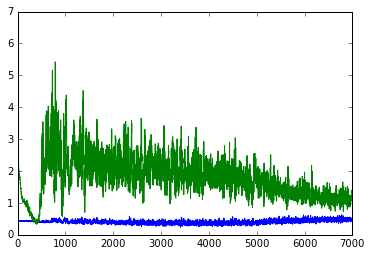

Fake image using label 6:


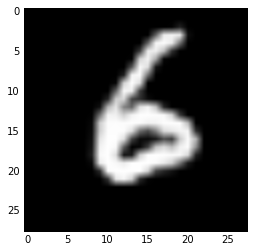

Fake image using label 0:


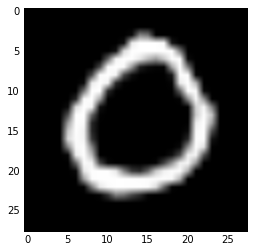

In [31]:
train(7000, d_losses, gan_losses)

Epoch 2980 out of 3000
D loss: 0.48984003067
GAN loss: 1.24583351612
Time elapsed in epoch 2980: 1.17 seconds


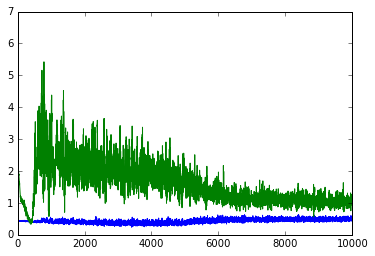

Fake image using label 7:


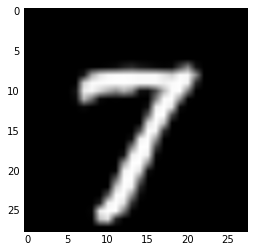

Fake image using label 0:


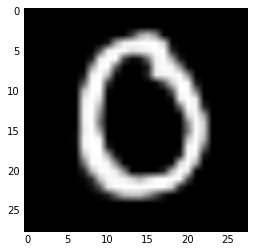

In [32]:
train(3000, d_losses, gan_losses)

In [44]:
d_opt.lr.set_value(1e-5)
gan_opt.lr.set_value(1e-5)

Epoch 4980 out of 5000
D loss: 0.422379344702
GAN loss: 1.04786217213
Time elapsed in epoch 4980: 1.16 seconds


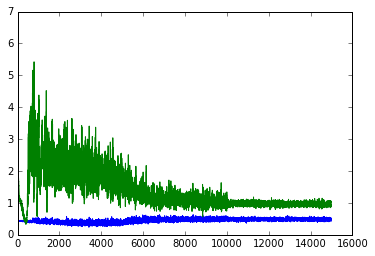

Fake image using label 4:


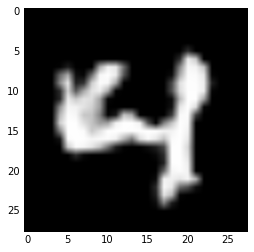

Fake image using label 4:


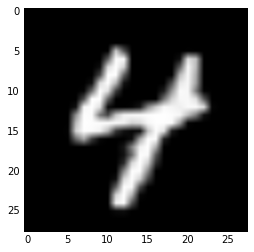

In [45]:
train(5000, d_losses, gan_losses)

Epoch 4980 out of 5000
D loss: 0.517723381519
GAN loss: 0.864308178425
Time elapsed in epoch 4980: 1.17 seconds


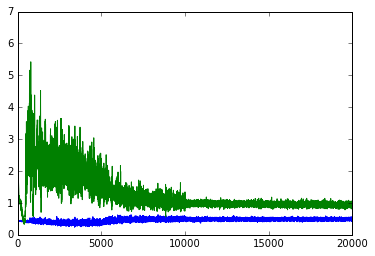

Fake image using label 0:


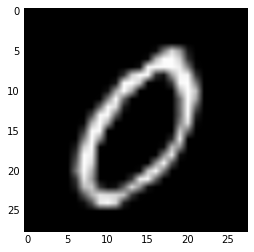

Fake image using label 4:


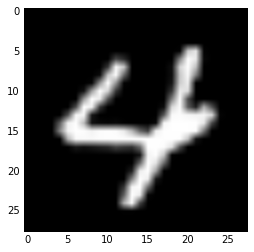

In [46]:
train(5000, d_losses, gan_losses)

In [ ]:
d_opt.lr.set_value(1e-6)
gan_opt.lr.set_value(1e-6)

In [ ]:
train(10000, d_losses, gan_losses)

## Test GAN

Fake image using label 7:


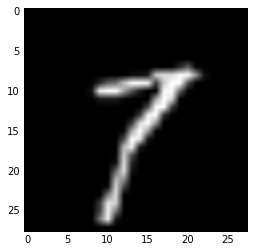

Fake image using label 6:


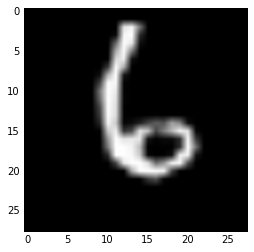

Fake image using label 7:


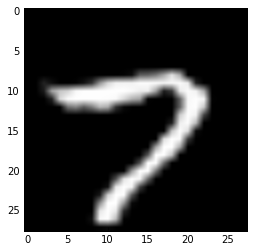

Fake image using label 6:


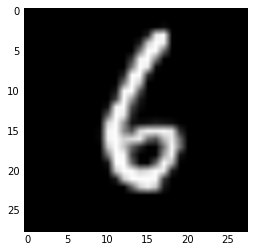

Fake image using label 2:


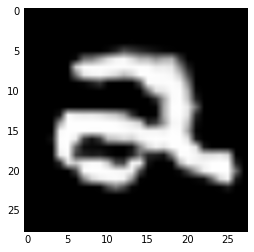

In [47]:
show_fake_images(5, generator)

In [34]:
def show_all_labels(n, g_model):
    plt.figure(figsize=(10,10))
    for l in range(10):
        noise = np.random.uniform(0, 1, size=[n, noise_dim])
        labels = np_utils.to_categorical([l]*n, num_classes=nb_classes)
        fake_images = g_model.predict([noise, labels], verbose=0)

        for i, img in enumerate(fake_images):
            plt.subplot(10, n, (l*n)+i+1)
            plt.imshow(img[:,:,0], cmap=plt.cm.gray);
            plt.axis('off')

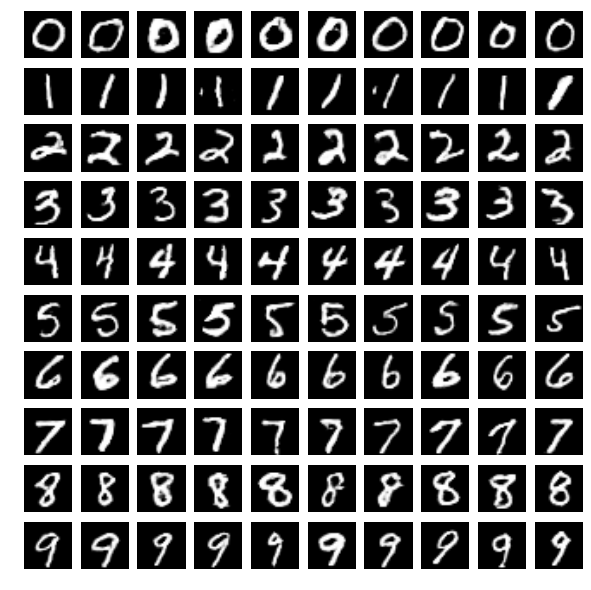

In [48]:
show_all_labels(10, generator)

In [ ]:
discriminator.save('discriminator-march-17-20k.h5')

In [50]:
generator.save('generator-march-17-10k.h5')